# Steady-state torsional vibration in the crankshaft of an internal combustion engine

Calculation of the steady-state torsional vibration in the crankshaft of an internal combustion engine. Torque produced by each cylinder is calculated from the force produced by the pressure from ignition which is scaled according to the rotation speed of the crankshaft. Torsional vibration analysis based on the article "Analysis of torsional vibration in internal combustion engines: Modelling and experimental validation" [1]. The model is based on Fig.4 of the original article.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

import opentorsion
from opentorsion import Shaft
from opentorsion import Disk
from opentorsion import Assembly

In [2]:
def pressure_curve():
    '''Load digitized pressure curve from csv and pass it to interpolator'''
    curve = np.genfromtxt('ICE_example_data/pressure_data.csv', delimiter=';')
    
    return scipy.interpolate.interp1d(curve[:, 0], curve[:, 1])

In [3]:
def peak_pressures():
    '''Load digitized peak pressure from csv and pass it to interpolator'''
    curve = np.genfromtxt('ICE_example_data/peak_data.csv', delimiter=';')
    
    return scipy.interpolate.interp1d(curve[:, 0], curve[:, 1])

In [4]:
def scaled_cylinder_pressure(rpm, num_points):
    '''
    Scales the cylinder pressure curve based on the variation 
    of peak pressure with engine speed.

    Arguments
    ---------
    rpm: float
        Rotating speed of the engine in rpm
    num_points: int
        Number of points in x-axis

    Returns
    -------
    angles: np.ndarray
        Angles for which the cylinder pressures are given
    scaled_curve: np.ndarray
        The scaled pressure curve scaled to the given rpm corresponding
        to the angles. (Pa)
    '''
    # Load the base pressure curve
    angles = np.linspace(0, 720, num_points)
    base_curve = pressure_curve()
    base_curve_sampled = base_curve(angles)/15.2
    # Scale with the peak pressure
    pressures = peak_pressures()
    scaling = pressures(rpm)
    scaled_curve = base_curve_sampled*scaling*1e6
    
    return angles, scaled_curve

In [5]:
def calculate_cylinder_torque(speed_rpm, num_points=500):
    '''
    Calculates the torque produced by a single cylinder at given rpm.
    Torque is based on the tangential force caused by the pressure in the cylinder and the tangential component
    of the oscillating inertial force from the crankshaft spinning.
    
    Parameters
    ----------
    speed_rpm: float
        Current rotation speed in rpm
    num_points: float, optional
        Number of points for the x-axis

    Returns
    -------
    M_t: ndarray
        The torque produced by the cylinder
    alpha: ndarray
        Angles for which the cylinder torques are given
    '''
    def alpha_to_beta(alpha, r, l_rod):
        return np.arcsin(r/l_rod * np.sin(alpha))
    
    l_rod = 0.207  # m
    d_piston = 0.105  # m
    r = 0.137 / 2  # m (piston stroke / 2) crankshaft radius
    m_a = 2.521  # kg

    alpha_deg, p_curve = scaled_cylinder_pressure(speed_rpm, num_points)
    alpha = alpha_deg/180*np.pi
    w = speed_rpm/60*2*np.pi

    F_g = p_curve * 0.25*np.pi*d_piston**2
    beta = alpha_to_beta(alpha, r, l_rod)
    F_tg = F_g * np.sin(alpha + beta) * 1/np.cos(beta)        # Tangential gas load
    lambda_rl = r/l_rod
    F_ia = -m_a*r*(np.cos(alpha)
                   + lambda_rl*np.cos(2*alpha)
                   - lambda_rl**3*1/4 * np.cos(4*alpha)
                   + 9*lambda_rl**5*np.cos(6*alpha)/128)*w**2 # Oscillating inertial force
    F_ta = F_ia * np.sin(alpha + beta) * 1/np.cos(beta)       # Tangential inertial force
    F_t = F_tg + F_ta      # Total tangential force
    M_t = F_t * r
    
    return M_t, alpha

In [6]:
def calculate_dft_components(signal, t, num_harmonics):
    '''
    Calculates dft components and harmonics (0,0.5,1,...) for the given signal, to be used at stedy-state
    vibration calculations.

    Parameters
    ----------
    signal: ndarray
        Cylinder torque
    t: ndarray
        Crankshaft rotation angle
    num_harmonics: float
        Number of harmonics considered

    Returns
    -------
    complex ndarray
        The first num_harmonics complex components of the Fourier transform
    complex ndarray
        The first num_harmonics components of the harmonics
    '''
    dft = np.fft.rfft(signal)/len(signal)
    dft[1:] *= 2
    omegas = np.fft.rfftfreq(len(signal))*1/(t[1]-t[0])*2*np.pi
    
    return [dft[:num_harmonics], omegas[:num_harmonics]]

In [7]:
def crankshaft_assembly():
    '''
    A shaft-line Finite Element Model of a crankshaft based on model presented
    in https://doi.org/10.1243/14644193JMBD126 Fig.4.

    Returns
    -------
    assembly: openTorsion Assembly class instance
        The created opentorsion assembly
    '''
    J2  = 0.0170
    J3  = 0.0090
    J4  = 0.0467
    J5  = 0.0327
    J6  = 0.0467
    J7  = 0.0467
    J8  = 0.0327
    J9  = 0.0487
    J10 = 2.0750

    k2 = 1.106e6
    k3 = 1.631e6
    k4 = 1.253e6
    k5 = 1.253e6
    k6 = 1.678e6
    k7 = 1.253e6
    k8 = 1.253e6
    k9 = 1.976e6

    c_a = 2 # absolute damping
    shafts, disks = [], []
    disks.append(Disk(0, J2))
    shafts.append(Shaft(0, 1, None, None, k=k2, I=0))
    disks.append(Disk(1, J3))
    shafts.append(Shaft(1, 2, None, None, k=k3, I=0))
    disks.append(Disk(2, J4, c=c_a)) # cylinder 1
    shafts.append(Shaft(2, 3, None, None, k=k4, I=0))
    disks.append(Disk(3, J5, c=c_a))
    shafts.append(Shaft(3, 4, None, None, k=k5, I=0))
    disks.append(Disk(4, J6, c=c_a))
    shafts.append(Shaft(4, 5, None, None, k=k6, I=0))
    disks.append(Disk(5, J7, c=c_a))
    shafts.append(Shaft(5, 6, None, None, k=k7, I=0))
    disks.append(Disk(6, J8, c=c_a))
    shafts.append(Shaft(6, 7, None, None, k=k8, I=0))
    disks.append(Disk(7, J9, c=c_a)) #cylinder 6
    shafts.append(Shaft(7, 8, None, None, k=k9, I=0))
    disks.append(Disk(8, J10)) # flywheel
    assembly = Assembly(shafts, disk_elements=disks)
    
    return assembly

In [8]:
def relative_damping_C(assembly, d, w):
    '''
    Updates the damping matrix C of assembly when using frequency dependent relative damping.

    Parameters
    ----------
    assembly: openTorsion Assembly class instance
        The assembly of whose damping matrix is to be updated
    d: float
        Loss factor property, used to calculate relative damping
    w: float
        Angular frequency of the system, used to calculate relative damping

    Returns
    -------
    C: ndarray
        The damping matrix assembled with new component specific damping coefficients
    '''
    if w!=0:
        c_r = d/w
    else:
        c_r = 0
    C = np.zeros((assembly.check_dof(), assembly.check_dof()))

    if assembly.shaft_elements is not None:
        for element in assembly.shaft_elements:
            dof = np.array([element.nl, element.nr])
            C[np.ix_(dof, dof)] += c_r*element.K()

    if assembly.disk_elements is not None:
        for element in assembly.disk_elements:
            C[element.node, element.node] += element.C()

    if assembly.gear_elements is not None:
        for element in assembly.gear_elements:
            C[element.node, element.node] += element.C()

        # Build transformation matrix
        E = assembly.E()
        transform = assembly.T(E)
        # Calculate transformed mass matrix
        C = np.dot(np.dot(transform.T, C), transform)
        
    return C

In [9]:
def calculate_response(crankshaft, rpm):
    '''
    Calculates the crankshaft's response to excitation at given rpm.
    
    Parameters
    ----------
    crankshaft: openTorsion Assembly class instance
        Opentorsion Assembly of the crankshaft
    rpm: float
        Current rotation speed in rpm

    Returns
    -------
    sum_response: ndarray
        Array containing maximum vibratory torque at current rotation speed for each shaft
    '''
    dof = 9
    cylinder_torque, alpha = calculate_cylinder_torque(rpm)
    dft_parameters, harmonics = calculate_dft_components(cylinder_torque, alpha, 25)
    q = np.zeros([dof, len(harmonics)], dtype='complex128')
    M = crankshaft.M
    K = crankshaft.K
    d = 0.035
    for i in range(len(harmonics)):
        # build T vector
        offset = 2 # offset to the first cylinder
        phase_shift = 2/3*np.pi
        T = np.zeros(dof, dtype='complex128')
        T[offset]   = dft_parameters[i]
        T[offset+1] = dft_parameters[i]*np.exp( 2.0j*phase_shift*harmonics[i])
        T[offset+2] = dft_parameters[i]*np.exp(-2.0j*phase_shift*harmonics[i])
        T[offset+3] = dft_parameters[i]*np.exp( 1.0j*phase_shift*harmonics[i])
        T[offset+4] = dft_parameters[i]*np.exp(-1.0j*phase_shift*harmonics[i])
        T[offset+5] = dft_parameters[i]*np.exp( 3.0j*phase_shift*harmonics[i])
        w = harmonics[i]*rpm*2*np.pi/60
        C = relative_damping_C(crankshaft, d, w)
        receptance = np.linalg.inv(-w**2*M+1.0j*w*C+K)
        q.T[i] = receptance @ T
    # Calculate the angle difference between two consecutive disks
    q_difference = (q.T[:, 1:] - q.T[:, :-1]).T
    shaft_list = crankshaft.shaft_elements
    shaft_ks = np.array([shaft.k for shaft in shaft_list])
    # Multiply the angle difference between two disks with the connecting shaft stiffness to get
    # the torque in the shaft
    q_response = (shaft_ks*q_difference.T).T
    for i in range(dof-1):
        shaft_i = q_response[i]
        sum_wave = np.zeros_like(alpha)
        for i in range(len(shaft_i)):
            this_wave = np.real(shaft_i[i]*np.exp(1.0j*harmonics[i]*alpha))
            sum_wave += this_wave
    sum_response = np.sum(np.abs(q_response), axis=1)
    
    return sum_response

In [10]:
def plot_results(rpms, vibratory_torque):
    '''
    Plots the vibratory torque in wanted shafts for each considered engine speed.
    
    Parameters
    ----------
    rpms: ndarray
        All considered engine speeds in rpm
    vibratory_torque: ndarray
        Matrix containing maximum vibratory torque at each rotation speed for each shaft.
        Each row correspond to an engine speed and each column to a shaft.

    Returns
    -------
    shaft_8: ndarray
        Array containing maximum vibratory torque at all considered engine speeds for shaft 
        between flywheel and 6th cylinder
    shaft_1: ndarray
        Array containing maximum vibratory torque at all considered engine speeds for shaft
        between crankshaft pulley and gear train
    '''
    shaft_8 = [shaft[7] for shaft in vibratory_torque]
    plt.plot(rpms, shaft_8, c='red', label='calculated')
    plt.xlabel('Engine speed (rpm)')
    plt.ylabel('Vibratory torque (Nm)')
    plt.title('Torque between the flywheel and the 6th cylinder (Fig.31)')
    plt.figure()
    shaft_1 = [shaft[0] for shaft in vibratory_torque]
    plt.plot(rpms, shaft_1, c='red', label='calculated')
    plt.xlabel('Engine speed (rpm)')
    plt.ylabel('Vibratory torque (Nm)')
    plt.title('Torque between the crankshaft pulley and the gear train (Fig.32)')
    plt.figure()
    
    return shaft_8, shaft_1

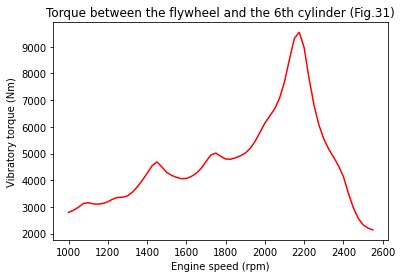

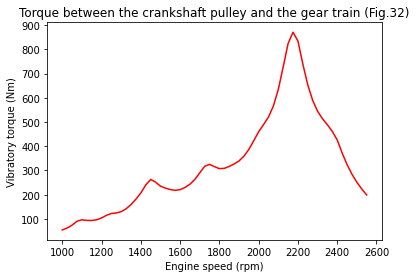

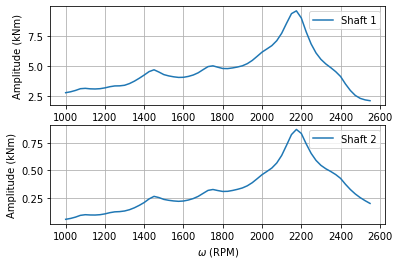

In [11]:
assembly = crankshaft_assembly()
rpms = np.arange(1000, 2575, 25)
# Vibratory torque for every shaft and every considered engine speed
vibratory_torque = []
for rpm in rpms:
    vibratory_torque.append(calculate_response(assembly, rpm))

shaft_8, shaft_1 = plot_results(rpms, vibratory_torque)
# Same plots but using openTorsions Plots class
plots = opentorsion.Plots(assembly)
plots.torque_response_plot(rpms, [np.array(shaft_8), np.array(shaft_1)], True)

[1] Mendes AS, Meirelles PS, Zampieri DE. Analysis of torsional vibration in internal combustion engines: Modelling and experimental validation. Proceedings of the Institution of Mechanical Engineers, Part K: Journal of Multi-body Dynamics. 2008;222(2):155-178. doi:10.1243/14644193JMBD126